In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

/Users/paulag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

In [3]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [4]:
oni = ONI(nino34)

In [5]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [6]:
clm = climatology(nino34)

In [7]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [8]:
anm = SST_anomaly(nino34, clm)
oanm = ONI(anm)

In [9]:
T = 12 * 6  # prediction timeline
H = 3   # history used for prediction
Hmax = 24
extra_features = 4 # running mean of 6/12/24 + month

signal = np.array(nino34)   # data used for training/testing
length = signal.shape[0]    # number of data points

mean = np.mean(signal)
std = np.std(signal)

signal = (signal - mean) / std

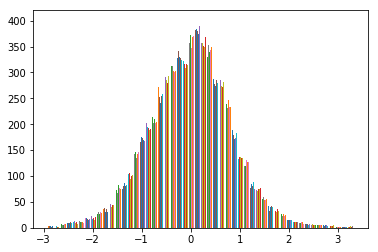

In [10]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H + extra_features))
for i in range(size):
    data[i, 0:H] = signal[i:(i + H)]
    data[i, H] = np.mean(signal[i:(i + 6)])
    data[i, H+1] = np.mean(signal[i:(i + 6 * 2)])
    data[i, H+2] = np.mean(signal[i:(i + 6 * 4)])
    data[i, H+3] = ((i + H) % 12 - np.mean(range(12))) / np.std(range(12))
    

labels = np.ndarray((size, T), dtype = np.float64)

for t in range(T):
    for i in range(size):
        labels[i,t] = anm[i + H + t]

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

plt.hist(train_labels, bins=50);

In [11]:
(N1, N2, N3, d) = (192, 768, 768, 0.5)
epochs = 40

model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(T,  kernel_initializer='normal', activation = 'linear')
        ])

model.reset_states()

model.compile(optimizer='adam',
                    loss='mae',
                    metrics=['mse', 'mae'])

history = model.fit(train, train_labels, epochs = epochs, verbose = 1)
(loss, mse, mae) = model.evaluate(val, val_labels, verbose = 0)

print(mse, mae)

Epoch 1/40
5696/5696 [==============================] - 3s 535us/step - loss: 0.5520 - mean_squared_error: 0.5377 - mean_absolute_error: 0.5520
Epoch 2/40
5696/5696 [==============================] - 2s 438us/step - loss: 0.5235 - mean_squared_error: 0.5008 - mean_absolute_error: 0.5235
Epoch 3/40
5696/5696 [==============================] - 3s 484us/step - loss: 0.5172 - mean_squared_error: 0.4935 - mean_absolute_error: 0.5172
Epoch 4/40
5696/5696 [==============================] - 3s 459us/step - loss: 0.5141 - mean_squared_error: 0.4905 - mean_absolute_error: 0.5141
Epoch 5/40
5696/5696 [==============================] - 2s 428us/step - loss: 0.5117 - mean_squared_error: 0.4880 - mean_absolute_error: 0.5117
Epoch 6/40
5696/5696 [==============================] - 3s 479us/step - loss: 0.5097 - mean_squared_error: 0.4859 - mean_absolute_error: 0.5097
Epoch 7/40
5696/5696 [==============================] - 3s 449us/step - loss: 0.5081 - mean_squared_error: 0.4840 - mean_absolute_error:

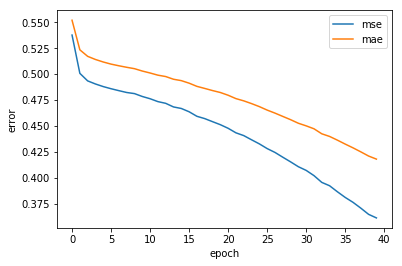

In [12]:
plt.plot(history.history['mean_squared_error'], label = "mse");
plt.plot(history.history['mean_absolute_error'], label = "mae");
plt.legend();
plt.ylabel('error');
plt.xlabel('epoch');

In [13]:
pred_val = model.predict(val)

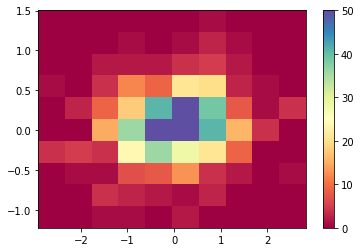

In [14]:
plt.hist2d(val_labels[:,-1], pred_val[:,-1], cmap = plt.cm.Spectral, vmax = 50);
plt.colorbar();

In [15]:
def correlation(x, y):
    x0 = x - np.mean(x, axis = 0)
    y0 = y - np.mean(y, axis = 0)
    return np.mean(x0 * y0, axis = 0) / np.sqrt((np.mean(x0**2, axis = 0) * (np.mean(y0**2, axis = 0))))

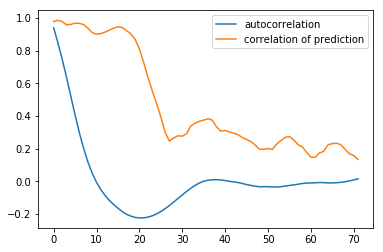

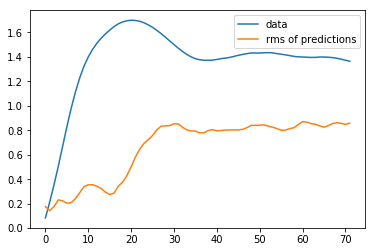

In [16]:
auto = np.zeros(T)
rms = np.zeros(T)

for t in range(T):
    auto[t] = correlation(anm[:(- t - 1)], anm[(t + 1):])
    rms[t] = mean_squared_error(anm[:(- t - 1)], anm[(t + 1):])
    
pred_rms_val = np.sqrt(((val_labels - pred_val)**2).mean(axis = 0))

plt.plot(auto, label = "autocorrelation");
plt.plot(correlation(val_labels, pred_val), label = "correlation of prediction");
plt.legend();
plt.figure();
plt.plot(rms, label = "data");
plt.plot(pred_rms_val, label = "rms of predictions")
plt.legend();

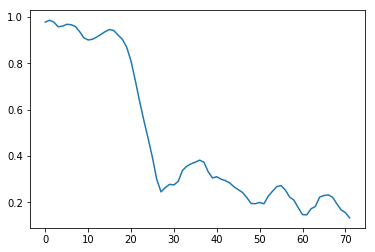

In [17]:
plt.plot(correlation(val_labels, pred_val));

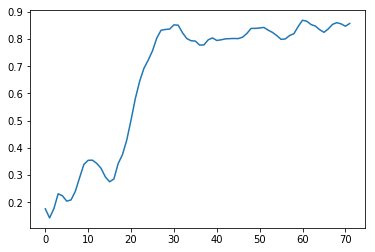

In [18]:
plt.plot(pred_rms_val);

# Performance on real data

In [19]:
datapath = 'om_nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
nino34 = np.array((nino34['nino34'].values))

/Users/paulag/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'areacello' has multiple fill values {-1e+34, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


In [20]:
clm = climatology(nino34)
anm = SST_anomaly(nino34, clm)

In [21]:
signal = np.array(nino34)   # data used for training/testing
length = signal.shape[0]    # number of data points

mean = np.mean(signal)
std = np.std(signal)

signal = (signal - mean) / std

In [22]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H + extra_features))
for i in range(size):
    data[i, 0:H] = signal[i:(i + H)]
    data[i, H] = np.mean(signal[i:(i + 6)])
    data[i, H+1] = np.mean(signal[i:(i + 6 * 2)])
    data[i, H+2] = np.mean(signal[i:(i + 6 * 4)])
    data[i, H+3] = ((i + H) % 12 - np.mean(range(12))) / np.std(range(12))

labels = np.ndarray((size, T), dtype = np.float64)

for t in range(T):
    for i in range(size):
        labels[i,t] = anm[i + H + t]

In [23]:
pred = model.predict(data)

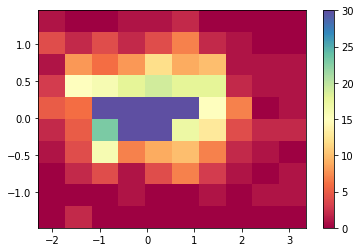

In [24]:
plt.hist2d(labels[:,-1], pred[:,-1], cmap = plt.cm.Spectral, vmax = 30);
plt.colorbar();

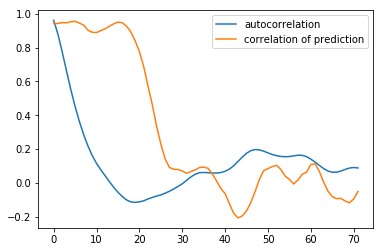

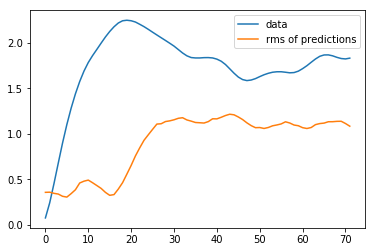

In [25]:
auto = np.zeros(T)
rms = np.zeros(T)

for t in range(T):
    auto[t] = correlation(anm[:(- t - 1)], anm[(t + 1):])
    rms[t] = mean_squared_error(anm[:(- t - 1)], anm[(t + 1):])
    
pred_rms = np.sqrt(((labels - pred)**2).mean(axis = 0))

plt.plot(auto, label = "autocorrelation");
plt.plot(correlation(labels, pred), label = "correlation of prediction");
plt.legend();
plt.figure();
plt.plot(rms, label = "data");
plt.plot(pred_rms, label = "rms of predictions")
plt.legend();

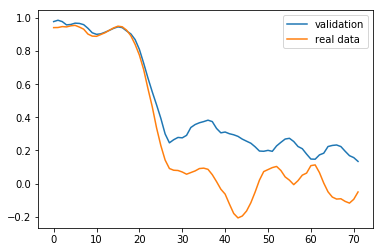

In [26]:
plt.plot(correlation(val_labels, pred_val), label = "validation");
plt.plot(correlation(labels, pred), label = "real data");
plt.legend();

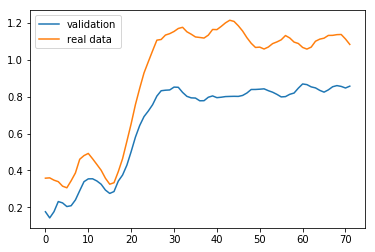

In [27]:
plt.plot(pred_rms_val, label = "validation");
plt.plot(pred_rms, label = "real data");
plt.legend();